# Practice: positional encoding
_This notebook is brought to you by [Vadim Shiianov](https://www.linkedin.com/in/binpord/), inspired by [Vladislav Goncharenko](https://www.linkedin.com/in/vladislav-goncharenko/)._

The transformer model introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762) uses positional encoding to enreach token embeddings with positional information. Authors note that there are several possible implementations of positional encoding, one of the most obvious ones being the trainable embedding layer. However, there are drawbacks to this approach, such as inability of model to work with sequences of length more than in training examples. Hence, authors search for alternative methods and settle for the following:

$$ PE_{(pos,2i)} = \sin \left( \frac{1}{10000^{2i/d_{\text{model}}}} pos \right) = \sin(\omega_i \cdot pos) $$

$$ PE_{(pos,2i+1)} = \cos \left( \frac{1}{10000^{2i/d_{\text{model}}}} pos \right) = \cos(\omega_i \cdot pos) $$

Authors note that this approach yields comparable results to the trainable embeddings plus has some additional pros, such as limited vector norm and linear relative position computation. However, to the unexperienced reader, these formulas may seem a bit like an arbitrary choice. Let's dig a little bit deeper to try to understand, how these embeddings work.

> **Note:** here and in code I will refer to resulting vectors as positional *embeddings*; I reserve the positional *encoding* term for a technique of obtaining such embeddings.

First, let's visualize our embeddings on a heatmap. Here the color would encode the value of embeddings' components, red implying (-1), gray meaning 0 and blue denoting 1. For this purpose we will implement a function which will accept embedding parameters, namely the embedding size, the number of items in sequence and the base for the power in denomenator of frequency $\omega_i$, and will compute the positional embeddings matrix.

> **Note:** the original idea of this visualization belongs to [this great blog post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def compute_pos_emb(seq_len, emb_size, denom_base, start_pos=0):
    # start_pos is a dirty hack, which allows to compute pos embeddins for the
    # middle elements in sequence, e.g. for 50th element without computing
    # embeddings for the whole sequence
    denom_pow = 2 * np.arange(emb_size // 2) / emb_size
    denom = denom_base ** denom_pow

    sincos_base = (start_pos + np.arange(seq_len)[:, None]) / denom[None, :]

    sin = np.sin(sincos_base)
    cos = np.cos(sincos_base)

    pos_emb = np.stack([sin, cos], axis=-1).reshape(seq_len, emb_size)

    return pos_emb


def plot_pos_emb(seq_len, emb_size, denom_base, start_pos=0, width=20):
    pos_emb = compute_pos_emb(seq_len, emb_size, denom_base, start_pos)
    height = int(width * (seq_len / emb_size))
    plt.figure(figsize=(width, height))
    plt.imshow(pos_emb, cmap="coolwarm_r")
    plt.axis("off")
    plt.show()

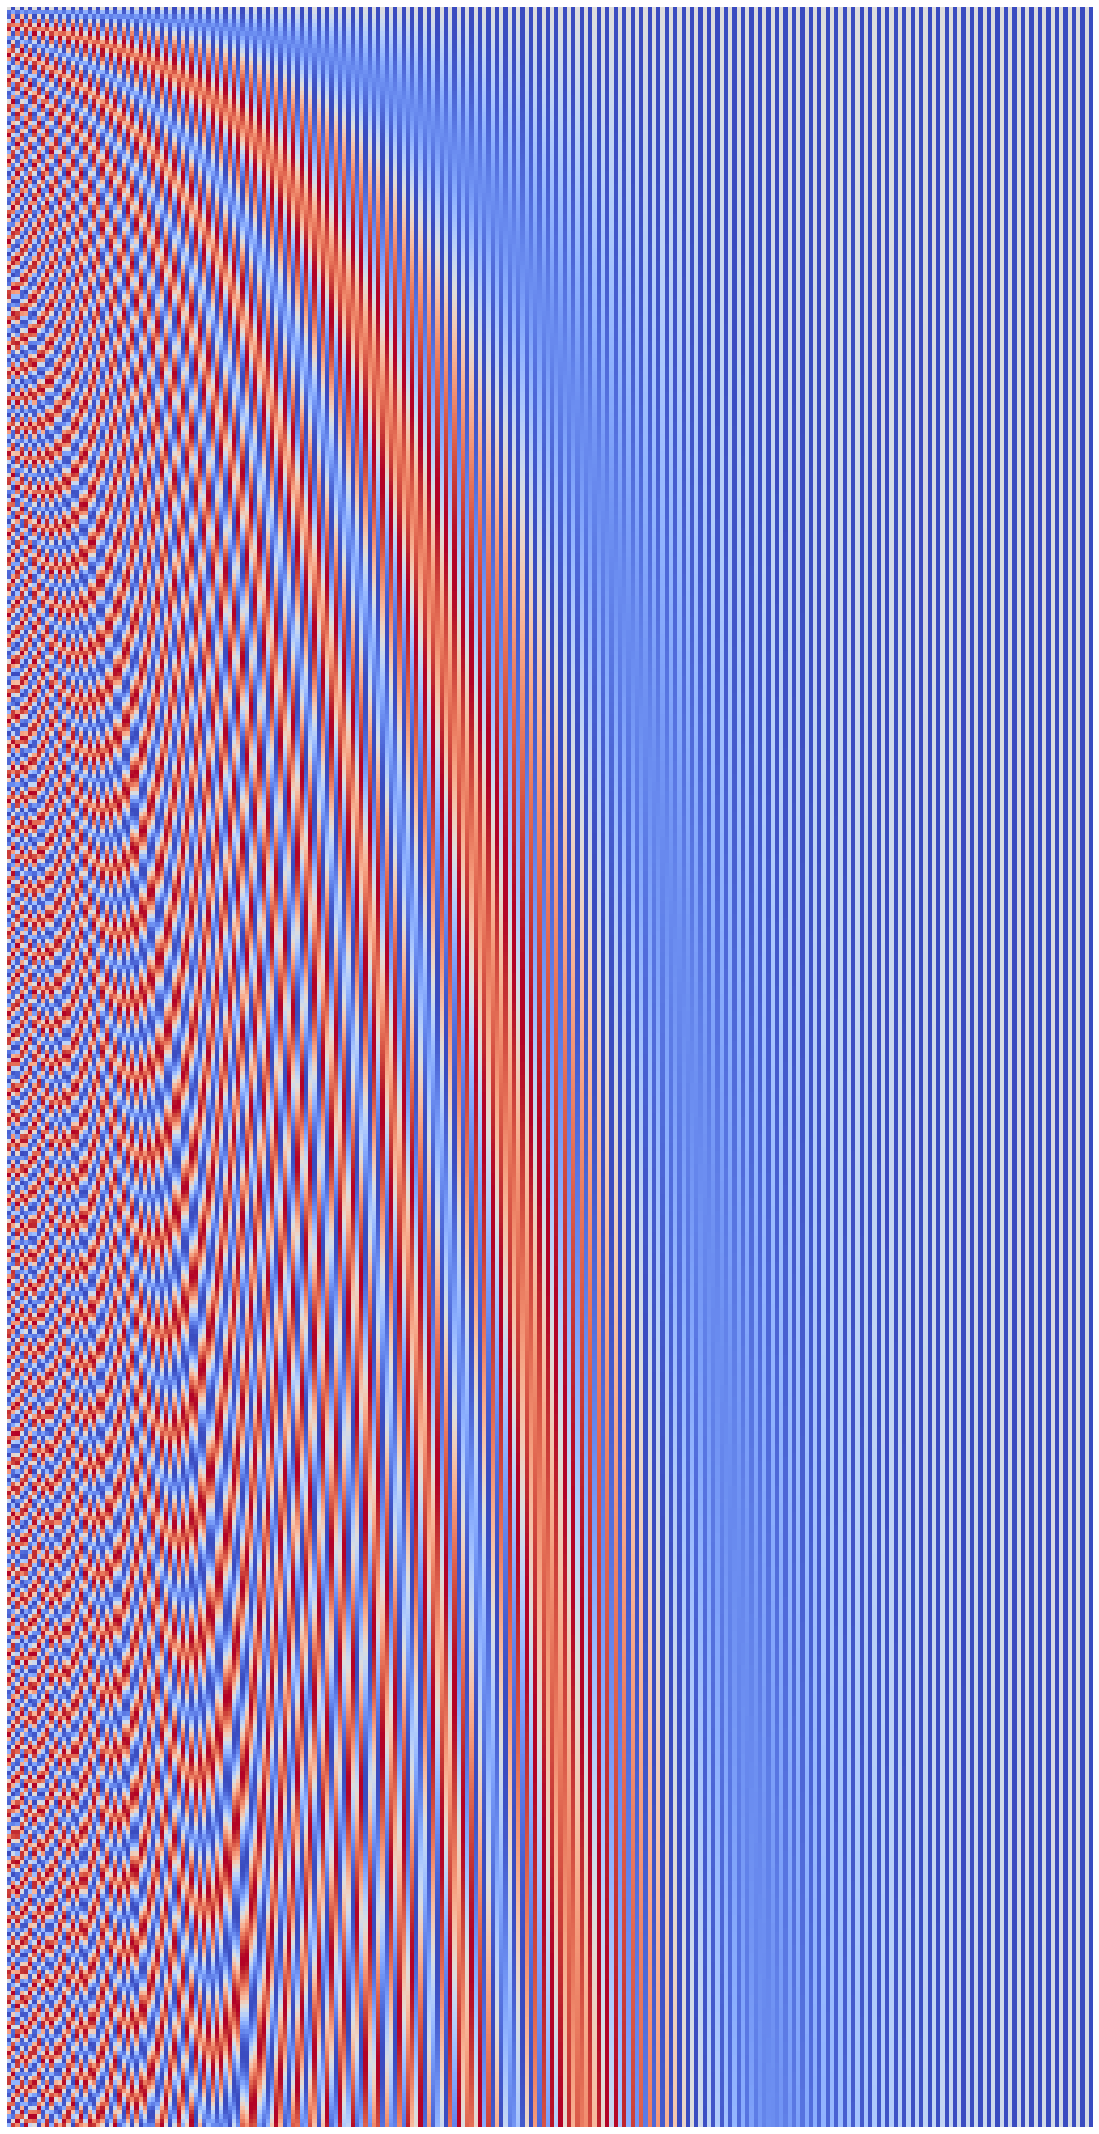

In [2]:
plot_pos_emb(seq_len=500, emb_size=256, denom_base=1e4)

Now that we can easily visualize our embeddings, let's play around with its parameters. Let's start with the `emb_size`. The frequences $\omega_i$ form a geometric progression from 1 to `1 / denom_base`, i.e. somewhat *evenly* cover the fixed (given the `denom_base` is fixed) range. This means that increasing our model's embedding size will simply yield the similar but smoother version of the original image. Let's check this hypothesis:

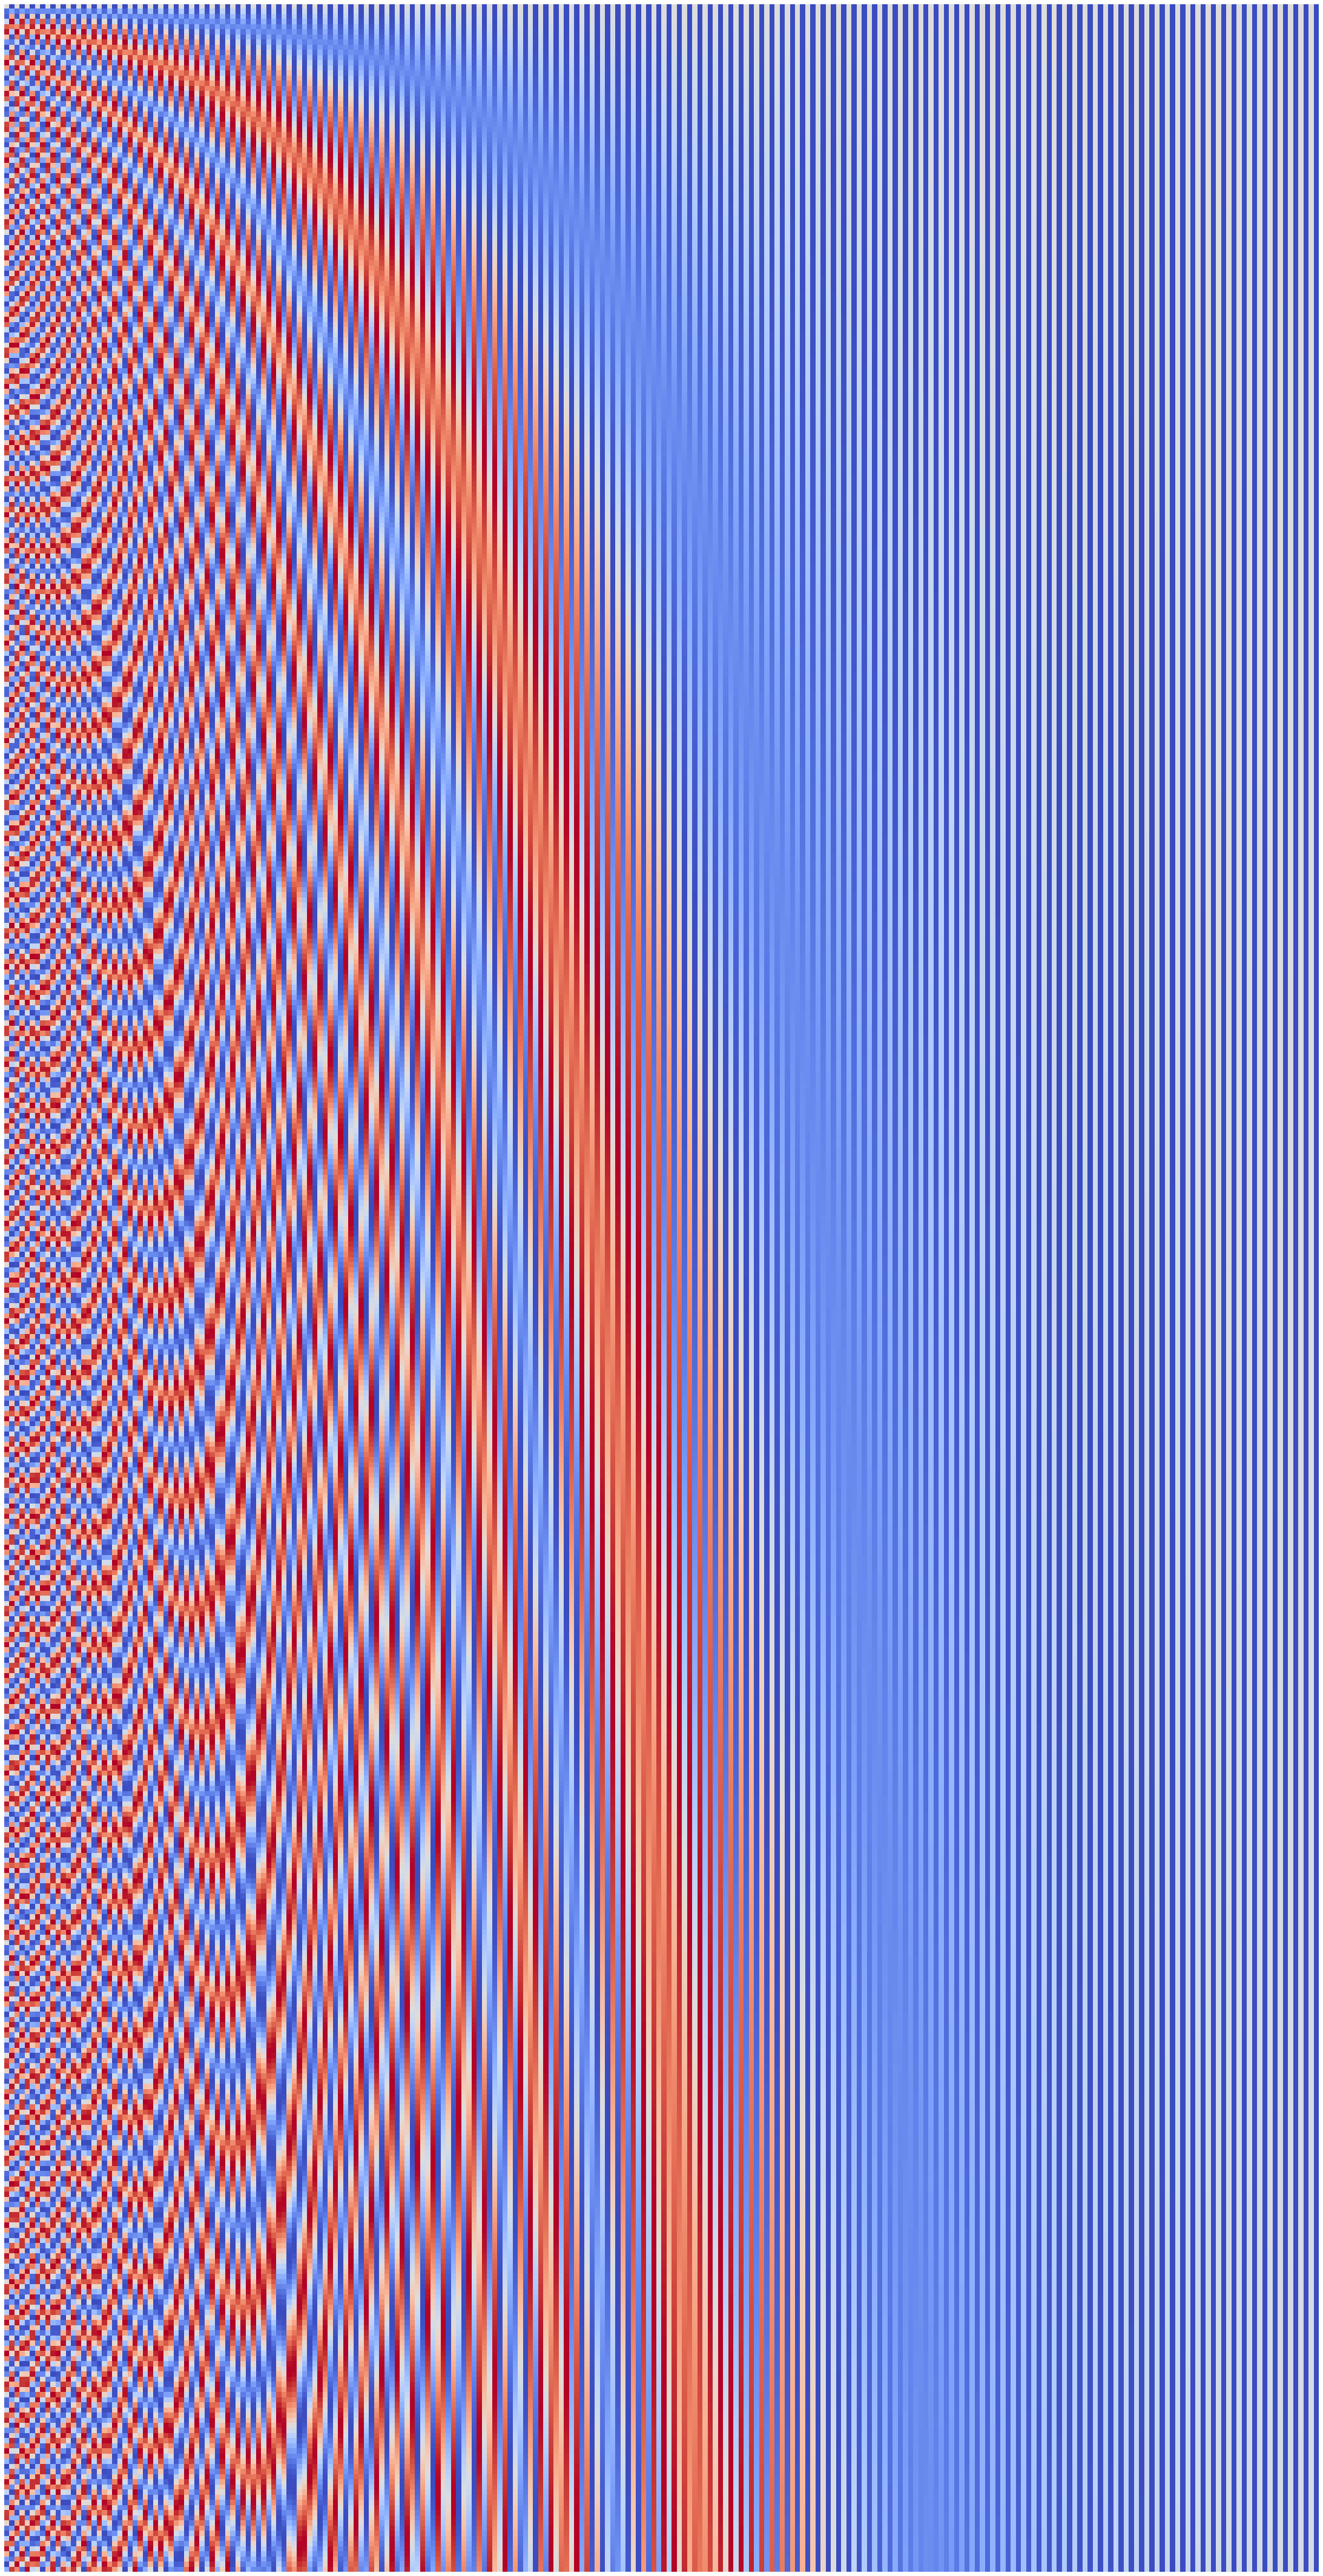

In [3]:
plot_pos_emb(seq_len=500, emb_size=256, denom_base=1e4, width=40)

Indeed, we see very similar image, but with more components on horizontal axis!

Another parameter of our embeddings is the `seq_len`. I mostly leave tinkering with this parameter for the interested readers, however I want to note one thing: when I tried to push the `seq_len` to 10,000 I received an exception from the `matplotlib`. However, 10,000 is not the limit! For this purpose I introduced a parameter `start_pos`, which can be used to surpass limitations of `matplotlib` and even speed up the plotting process. You can use it e.g. as follows:

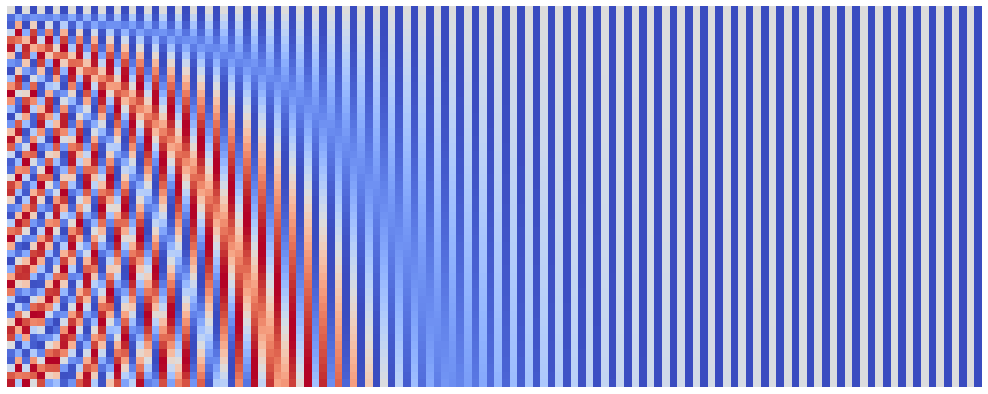

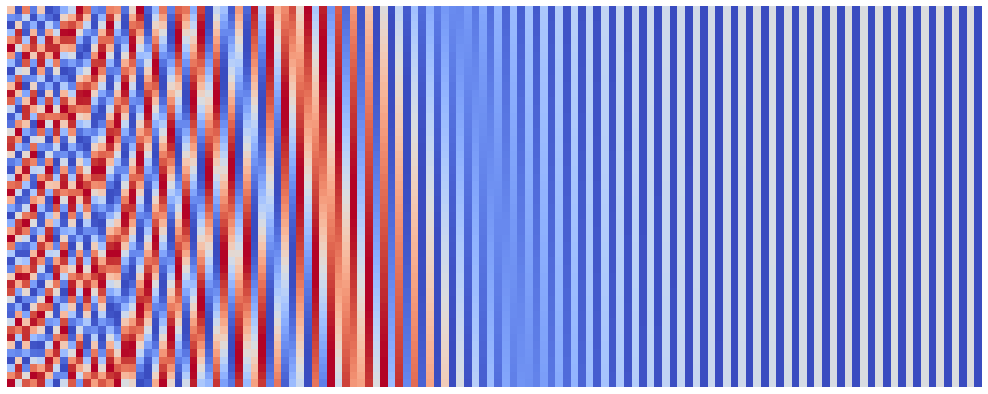

In [6]:
seq_len = 50
n_plots = 2
emb_size = 128
denom_base = 1e4
for start_pos in range(0, n_plots * seq_len, seq_len):
    plot_pos_emb(seq_len, emb_size, denom_base, start_pos)

After we eliminated the `emb_size` and `seq_len`, we actually got to the least obvious parameter - the `denom_base`. Proposed positional encoding splits the position information between `emb_size` frequences, the frequencies being:

$$ \omega_i = \frac{1}{10000^{2i / d_{model}}} $$

The frequency decreases with each new component and the decrease rate depends on the embedding size and the base number in denominator. Suppose we fixed the embedding size, then the base number will determine the steepness of frequency decrease:

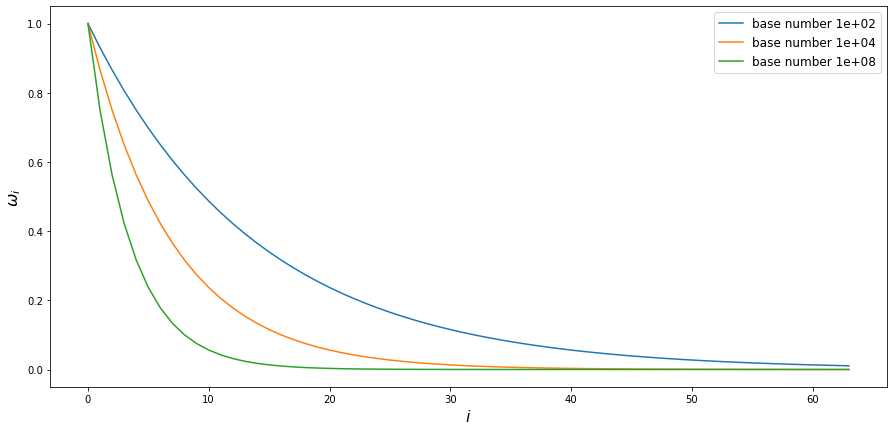

In [7]:
emb_size = 128
denom_pow = 2 * np.arange(emb_size // 2) / emb_size

plt.figure(figsize=(15, 7))
for denom_base in [1e2, 1e4, 1e8]:
    denom = denom_base ** denom_pow
    omega = 1 / denom
    plt.plot(omega, label=f"base number {denom_base:.0e}")

plt.xlabel("$i$", fontsize=16)
plt.ylabel("$\\omega_i$", fontsize=16)
plt.legend(fontsize=12)
plt.show()

So the bigger the base number is, the faster frequency decreases with the index in embedding vector. What does this mean? Well, the lower the frequency is, the less sinus/cosinus value changes with the same change in $pos$ argument. We already saw that in previous visualizations: first few components change with each change rapidly with every new position, whilst the last half of components seem to be almost constant for the first 50 positions. Given this observation, we could hypothesise that if we were to decrease the `denom_base` we would see more components changing rapidly and if we were to increase the `denom_base` we would see even less components changing at all. Let's check this hypothesis!

Here are position embeddings for `denom_base` of $10^2$:

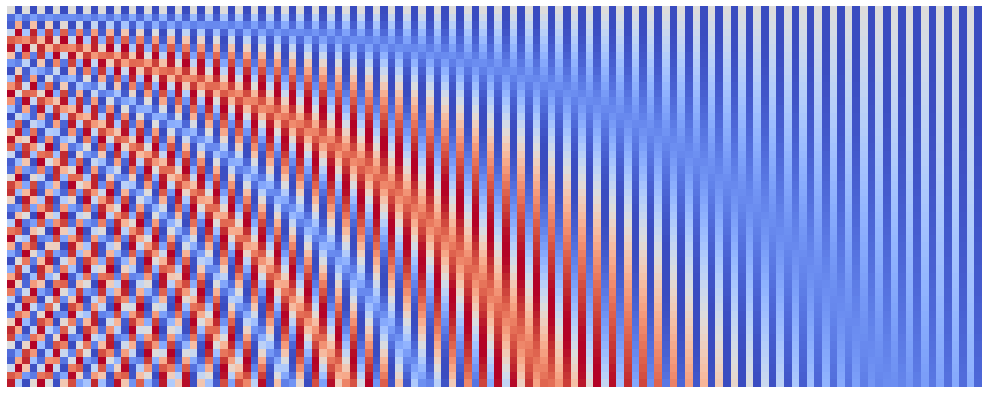

In [8]:
plot_pos_emb(seq_len=50, emb_size=128, denom_base=1e2)

And here are position embeddings for `denom_base` of $10^8$:

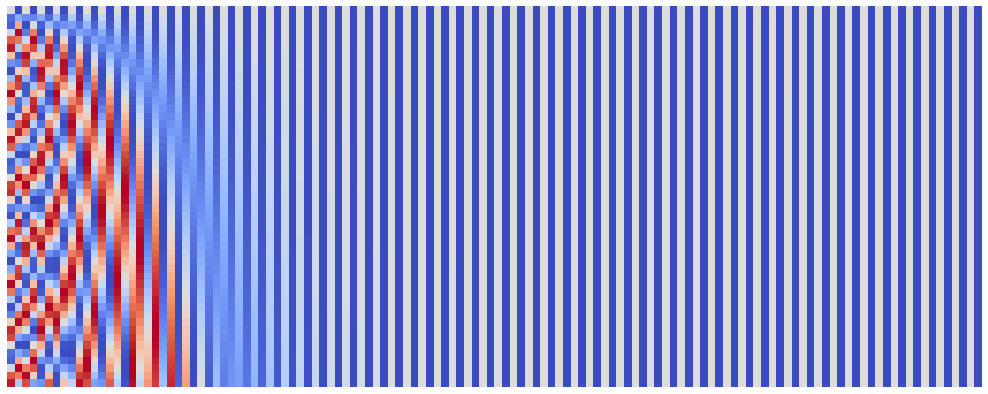

In [7]:
plot_pos_emb(seq_len=50, emb_size=128, denom_base=1e8)

Just like we expected!

> **Note:** it could be interesting to see what will happen with the increase of `seq_len`. Especially, I suggest you look for the sequences of size around 5,000 and more.

That's all we will get from our heatmap visualization. Can we visualize our embeddings in any other way? Sure we can! In order to understand the following visualization, recall that our embeddings consist of pairs of sinuses and cosinuses which share the angle. Such pairs have a wonderful property of lying on a unit circle (recall $\sin^2 \alpha + \cos^2 \alpha = 1$). Let's plot these pairs:

> **Note:** in the following plots color of points encodes the position of token, dark purple being the first token and bright green being the last.

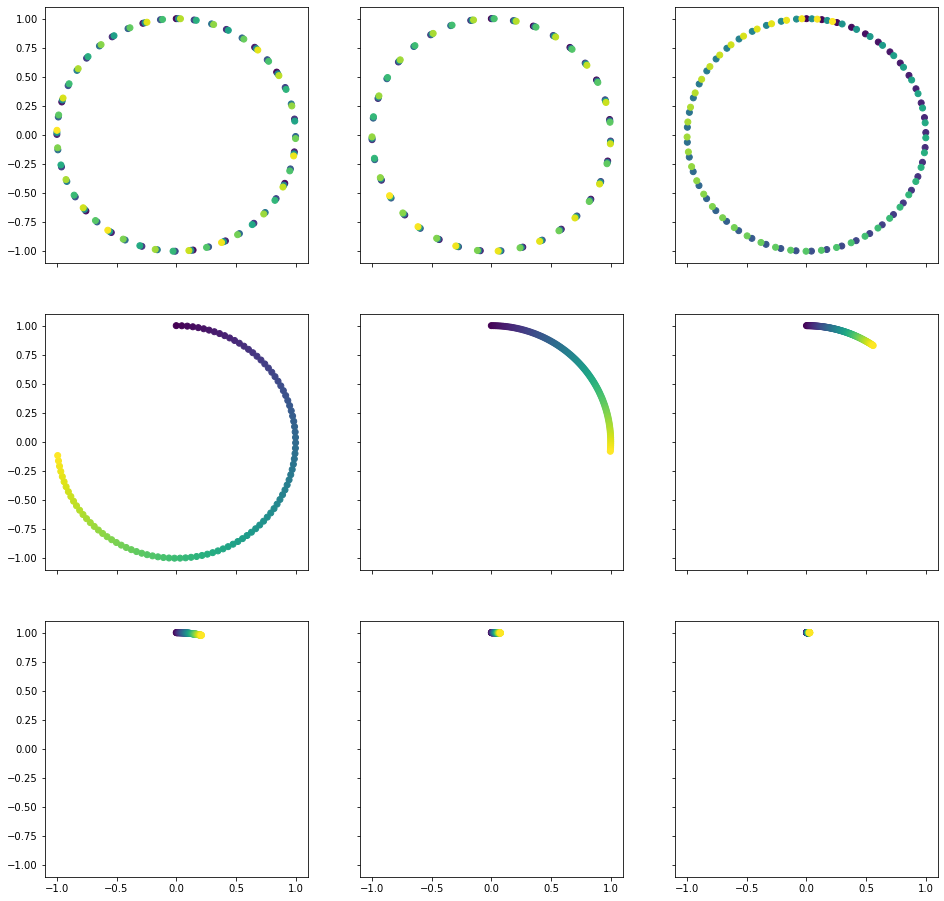

In [9]:
seq_len = 100
nrows = ncols = 3
emb_size = 2 * nrows * ncols
_, axes = plt.subplots(nrows, ncols, figsize=(16, 16), sharex=True, sharey=True)
pos_emb = compute_pos_emb(seq_len, emb_size, denom_base=1e4)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(pos_emb[:, 2 * i], pos_emb[:, 2 * i + 1], c=range(seq_len))

plt.show()

It might not be too easy to see from the top row, however, once you look at the second and third rows, you must see it! It works just like clocks! The point goes in clock-wise direction on a unit circle and each pair of values encodes position on a clock with its own time unit, just like second, minute and hour hands. First three circles are also clocks, however, the unit is so small for them, that each step leaps the hand forward too much and hence we see the distinct points and regions. This is how our model can understand, what position is it looking at. It just checks the clocks!

Once you get this intuition, it is easy to see, why there must be a linear translation between relative positions: you just have to turn the clocks a little.

What is the meaning of our parameters? The `seq_len` simply defines the amount of points we mark on our clocks. The `emb_size` gives us the amount of different units inbetween the most and least frequent clocks. Finally, the `denom_base` defines the minimal frequency (the maximal frequency $\omega_0$ always equals to 1 as we raise the base to the power of 0).

The last fact actually gives an insight as to why 10,000? Let's recall once more, that the bigger this number is the less frequent will all the clocks (save for the very first ones) be. Hence, we could fit more "time points" into them. However, the changes between two consequent points will be smaller, and thus harder for the model to see.

We don't want our base to be too little, as we will end up with too little time points in store and we don't want our base to be too big either, as it will make these points hard to distinguish. So the 10,000 is just a heuristic authors selected to fit both these criteria. The last clock tops out at around 22,500 tokens (don't take my word for it, though, try it yourself), which is a fair amount. Yet we use at least half of our embedding's dimensions even when working with a lesser sequences (as per our earlier visualizations), which also sounds sensible.